<a href="https://colab.research.google.com/github/itissandeep98/ML-Assignments/blob/master/ML_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess

In [3]:
class MyPreProcessor():
    """
    My steps for pre-processing for the three datasets.
    """

    def __init__(self):
        pass

    def pre_process(self, dataset):
        """
        Reading the file and preprocessing the input and output.
        Note that you will encode any string value and/or remove empty entries in this function only.
        Further any pre processing steps have to be performed in this function too. 

        Parameters
        ----------

        dataset : integer with acceptable values 0, 1, or 2
        0 -> Abalone Dataset
        1 -> VideoGame Dataset
        2 -> BankNote Authentication Dataset
        
        Returns
        -------
        X : 2-dimensional numpy array of shape (n_samples, n_features)
        y : 1-dimensional numpy array of shape (n_samples,)
        """     

        if dataset == 0:
            df=pd.read_csv('/content/Dataset.data',delim_whitespace=True,header=None) # data read from file
            df.sample(frac=1) # data shuffled

            # changed gender values to integers
            df[0].replace('M',1,inplace=True)
            df[0].replace('F',2,inplace=True)
            df[0].replace('I',3,inplace=True)

            data=df.to_numpy() # converted dataframe into numpy array
            X=data[:,:-1]
            y=data[:,-1]

        elif dataset == 1:
            df=pd.read_csv('/content/VideoGameDataset.csv') # data read from file
            df=df[['Critic_Score','Global_Sales','User_Score']] # required colums extracted
            df=df.sample(frac=1) # data shuffled

            df['Critic_Score'].fillna(df['Critic_Score'].mean(), inplace=True) # replaced NaN values with median of the column
            df['User_Score'].replace(to_replace = 'tbd', value = np.nan,inplace=True) # replaced the cell with 'tbd' value to NaN value in the colum
            df['User_Score']=df['User_Score'].astype(np.float) # converted column from strings to float values
            df['User_Score'].fillna(df['User_Score'].mean(), inplace=True) # replaced NaN values with median of the column

            data=df.to_numpy() # converted dataframe into numpy array
            X=data[:,:-1]
            y=data[:,-1]

        elif dataset == 2:
            # Implement for the banknote authentication dataset
            df=pd.read_csv('/content/data_banknote_authentication.txt',header=None) # data read from file
            df=df.sample(frac=1) # data shuffled
            X=df[[0,1,2,3]].to_numpy()
            y=df[[4]].to_numpy()
            y=y.squeeze()

        X=(X-X.mean(axis=0))/X.std(axis=0) # normalized the data 

        return X, y


# Linear Regression

In [26]:
class MyLinearRegression():
  """
	My implementation of Linear Regression.
	"""
  def __init__(self):
    pass

  def cross_validation(self,X,y,epoch=1000,alpha=0.01,k=10,lossfunc=1):
    """
    performs k fold cross validation on the given dataset

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) 

    y : 1-dimensional numpy array of shape (n_samples,)

    k : Number of folds the data needs to be splitted into

    epoch : Number of times gradient descent has to run

    alpha : Learning rate of gradient descent

    lossfunc: determines which loss function to call

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=X.shape[0] # number of samples

    split_start=0 # initial split's first index
    split_end=m//k # initial split's last index

    theta_list=[0]*k  # initialized theta
    training_loss_list=[0]*k  # initialized list to store all the training loss from every fold
    validation_loss_list=[0]*k # initialized list to store all the validation loss from every fold

    error_min=float("inf")
    idx=0

    for i in range(k):

      # Extracting X and y for train and test set
      X_train=np.concatenate((X[:split_start],X[split_end:]),axis=0)
      y_train=np.concatenate((y[:split_start],y[split_end:]),axis=0)

      X_test=X[split_start:split_end]
      y_test=y[split_start:split_end]

      self.fit(X_train,y_train,X_test,y_test,epoch,alpha,lossfunc) # calculating model parameters by running the gradient descent

      # storing the results of current fold in the array
      theta_list[i]=self.theta
      training_loss_list[i]=self.training_loss
      validation_loss_list[i]=self.validation_loss

      split_start=split_end # updating slice parameters
      split_end+=m//k

      error=training_loss_list[i][-1]


      # if the error in this fold is minimum of all errors seen upto now then update it and store the fold number
      if(error<error_min):
        idx=i
        error_min=error
    
    # final storing the values associated with minimum error 
    self.theta=theta_list[idx]
    self.training_loss=training_loss_list[idx]
    self.validation_loss=validation_loss_list[idx]

  def MSE(self,X,y,theta):
    """
    finding Mean Squared Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,)

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=len(y)

    X_trans=np.transpose(X)                                 # Transpose of vector X
    err=X.dot(theta)-y
    derv =(1/m)*(X_trans.dot(err))                         # Calculates X` * ( X*theta - y )
    
    return derv,sum(err**2)/m    
 
  def MAE(self,X,y,theta):
    """
    finding Mean Absolute Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,)

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=len(y)
    err=(1/m)*(X.dot(theta)-y)          # Calculates (1/m) *( X*theta - y )
    X_trans=X.T                         # Transpose of vector X
    epsilon=10**-7
    derv=(1/m)*(X_trans.dot(abs(err)/(err+epsilon)))

    return derv,np.sum(abs(err))           # returns gradient and sum((1/m) *( |X*theta - y |))

  def RMSE(self,X,y,theta):
    """
    finding Root Mean Squared Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,) 

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=len(y)
    X_trans=X.T                                          # Transpose of vector X
    diff=X.dot(theta)-y                                  # Calculates ( X*theta - y )
   
    err=((1/m)*np.sum((diff)**2))**0.5                   # Calculates (1/m) *sqrt(sum((X*theta - y)^2))
    derv =(1/m)*(X_trans.dot(diff))/err         
    
    return derv,err


  def gradient_descent(self,X,y,X_test,y_test,epochs,alpha,lossfunc):
    """
    Finding theta using the gradient descent method

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

    y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

    X_test : 2-dimensional numpy array of shape (n_samples, n_features) which acts as Testing data.

    y_test : 1-dimensional numpy array of shape (n_samples,) which acts as Testing labels.

    epochs : Number of times gradient descent has to run

    alpha : Learning rate of gradient descent

    lossfunc: determines which loss function to call

    Returns
    -------
    theta : Calculated value of theta on given test set (X,y) with learning rate alpha 

    training_loss: Calculated training loss at every theta

    tvalidation_loss: Calculated validation loss at every theta
    """
   
    theta= np.zeros((X.shape[1],))                      # created a column vector theta of length equal to number of features in X with all the initial values 0
    
    training_loss=np.array([])  # initializing array to store training loss at every value of theta
    validation_loss= np.array([]) # initializing array to store validation loss at every value of theta

    print("-*"*20)

    for i in range(epochs): 
      if(lossfunc==1): 
        derv,train_loss=self.RMSE(X,y,theta)   
      elif(lossfunc==2):   
        derv,train_loss=self.MAE(X,y,theta)
      else:
        derv,train_loss=self.MSE(X,y,theta)
      training_loss=np.append(training_loss,train_loss)

      

      if(X_test is not None): # calculate validation loss only if test set is provided
        if(lossfunc==1):
          derv_val,val_loss=self.RMSE(X_test,y_test,theta)   
        elif(lossfunc==2):   
          derv_val,val_loss=self.MAE(X_test,y_test,theta)
        else:
          derv_val,val_loss=self.MSE(X_test,y_test,theta)
      
        validation_loss=np.append(validation_loss,val_loss)
        if(i%400==0):
          print("Iteration:",i,"Training error:",train_loss,"Validation error:",val_loss)
      theta=theta-alpha*derv      
  
    return theta,training_loss,validation_loss

  def fit(self, X, y,X_test=None,y_test=None,epoch=400,alpha=0.01,lossfunc=1):
    """
    Fitting (training) the linear model.

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

    y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

    Returns
    -------
    self : an instance of self
    """

    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1) # Adding a bias variable i.e columns of 1 to data

    if(X_test is not None): # if validation set is provided then add a bias variable i.e columns of 1 to data
      X_test=np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1)
   
    X_trans=np.transpose(X)
    if(lossfunc==4):
      try:
        self.theta = np.linalg.inv(X_trans.dot(X)).dot(X_trans).dot(y)  # using the normal eqn, theta = inv(X`*X)*X`*y
      except:
        self.theta,self.training_loss,self.validation_loss = self.gradient_descent(X,y,X_test,y_test,epoch,alpha,lossfunc=1) # using the gradient descent method with RMSE loss function if the given data is non invertible
    else: 
      self.theta,self.training_loss,self.validation_loss = self.gradient_descent(X,y,X_test,y_test,epoch,alpha,lossfunc) # using the gradient descent method with given number of epochs and learning rate
      

    # fit function has to return an instance of itself or else it won't work with test.py
    return self


  def predict(self, X):
    """
    Predicting values using the trained linear model.

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

    Returns
    -------
    y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
    """
    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    y=np.dot(X,self.theta)
    # return the numpy array y which contains the predicted values
    return y

  def plot_loss(self):
    print("Thetas:",self.theta)
    print("Training Loss:",self.training_loss[-1])
    print("Validation Loss:",self.validation_loss[-1])
    
    x=np.arange(self.training_loss.shape[0])
    plt.plot(x,self.training_loss,color="g", label="Training Loss")
    plt.plot(x,self.validation_loss,color="r",label="Validation Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Dataset1

In [ ]:
preprocessor = MyPreProcessor()
X, y = preprocessor.pre_process(0)

linear = MyLinearRegression()
linear.fit(X,y,lossfunc=4)
print(linear.theta)
linear.cross_validation(X,y,epoch=10000,alpha=0.01,lossfunc=2)
linear.plot_loss()

## Dataset2

[ 7.12504611  0.51072865 -0.02992483]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Iteration: 0 Training error: 7.127312896491453 Validation error: 7.104632855760806
Iteration: 400 Training error: 3.2052905849244073 Validation error: 3.192771356822162
Iteration: 800 Training error: 0.45950048349692996 Validation error: 0.48303026134665206
Iteration: 1200 Training error: 0.4586564816514576 Validation error: 0.48322748740898347
Iteration: 1600 Training error: 0.45838211356644226 Validation error: 0.4830750183851089
Iteration: 2000 Training error: 0.4583709932394523 Validation error: 0.48287665036305083
Iteration: 2400 Training error: 0.45868593215449316 Validation error: 0.48334258268308267
Iteration: 2800 Training error: 0.45836624158977407 Validation error: 0.48306262827078345
Iteration: 3200 Training error: 0.45867781978227434 Validation error: 0.4833321115908642
Iteration: 3600 Training error: 0.45851438666175415 Validation error: 0.4832006179298973
Iteration: 4000 Training error: 0.4586

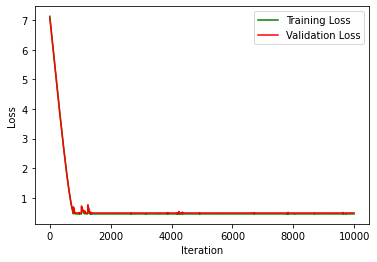

In [29]:
preprocessor = MyPreProcessor()
X, y = preprocessor.pre_process(1)

linear = MyLinearRegression()
linear.fit(X,y,lossfunc=4)
print(linear.theta)
linear.cross_validation(X,y, epoch=10000,alpha=0.01, lossfunc=2)
linear.plot_loss()

# Logistic Regression

In [40]:
class MyLogisticRegression():
	"""
	My implementation of Logistic Regression.
	"""

	def __init__(self):
		pass

	def sigmoid(self,z):
		"""
		Find the sigmoid value of z

		Parameters
		----------
		z : 1-dimensional numpy array of shape (n_samples,)

		Returns
		-------
		value of z in sigmoid function
		"""
		return 1/(1+np.exp(-z))
	def accuracy(self,y_hat,y):
		m=y.shape[0]
		y_hat[y_hat>=0.5]=1
		y_hat[y_hat<0.5]=0
		return (1-sum(abs(y-y_hat))/m)*100

	def cost_diff(self,X,y,theta):
		"""
		Find Log Loss error in current model parameters

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		theta : Value of theta at which derivative of cost has to be found

		Returns
		-------
		derv : derivative of cost at the value theta
		"""
		m=y.shape[0]
		X_trans=X.T		  	# Transpose of vector X
		z=X.dot(theta)
		activ =self.sigmoid(z)

		derv =(X_trans.dot(activ-y))		  # Calculates X` * ( sigmoid(X*theta) - y )

		err=(-1/m)*(np.sum(y*np.log(activ)+(1-y)*np.log(1-activ)))
	
		accuracy=self.accuracy(activ,y)

		return derv,err,accuracy


	def stochastic_gradient_descent(self,X,y,X_test=None,y_test=None,epoch=100,alpha=0.01):
		"""
		Finding theta using the stochastic gradient descent model

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		epochs : Number of times gradient descent has to run

		alpha : Learning rate of gradient descent

		Returns
		-------
		theta : Calculated value of theta on given test set (X,y) with learning rate alpha 
		"""
		m=y.shape[0]
		theta= np.zeros((X.shape[1],))		  # created a column vector theta of length equal to number of features in X with all the initial values 0
		
		validation_loss_list=np.array([])
		training_loss_list=np.array([])
		validation_acc_list=np.array([])
		training_acc_list=np.array([])
		for i in range(m):
			curr_X=np.array([X[i]])
			curr_y=np.array([y[i]])

			theta,val_loss,train_loss,val_acc,train_acc=self.batch_gradient_descent(curr_X,curr_y,X_test,y_test,theta)
	 
			validation_loss_list=np.concatenate((validation_loss_list,val_loss))
			training_loss_list=np.concatenate((training_loss_list,train_loss))
			training_acc_list=np.append(training_acc_list,train_acc)
			validation_acc_list=np.append(validation_acc_list,val_acc)
	
		
		return theta,validation_loss_list,training_loss_list,validation_acc_list,training_acc_list

	
	def batch_gradient_descent(self,X,y,X_test=None,y_test=None,theta=None,epoch=1000,alpha=0.01):
		"""
		Finding theta using the batch gradient descent model

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		epochs : Number of times gradient descent has to run

		alpha : Learning rate of gradient descent

		Returns
		-------
		theta : Calculated value of theta on given test set (X,y) with learning rate alpha 
		"""
		m=y.shape[0]
		if(theta is None):
			theta= np.zeros((X.shape[1],))		  # created a column vector theta of length equal to number of features in X with all the initial values 0
		
		validation_loss_list=np.array([])
		training_loss_list=np.array([])
	
		validation_acc_list=np.array([])
		training_acc_list=np.array([])

		for i in range(epoch):
			derv_train,loss_train,accuracy_train=self.cost_diff(X,y,theta)
			training_loss_list=np.append(training_loss_list,loss_train)
			training_acc_list=np.append(training_acc_list,accuracy_train)

			if(X_test is not None):
				derv_val,loss_val,accuracy_val=self.cost_diff(X_test,y_test,theta)
				validation_loss_list=np.append(validation_loss_list,loss_val)
				validation_acc_list=np.append(validation_acc_list,accuracy_val)
		
			theta=theta-(alpha/m)*derv_train
		
		return theta,validation_loss_list,training_loss_list,validation_acc_list,training_acc_list

	def fit(self, X, y,X_test=None,y_test=None,epoch=10000,alpha=0.01):
		"""
		Fitting (training) the logistic model.

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		Returns
		-------
		self : an instance of self
		"""
		X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1) # Adding a bias variable i.e columns of 1 to data

		if(X_test is not None): # if validation set is provided then add a bias variable i.e columns of 1 to data
			X_test=np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1)
		
		# self.theta,self.validation_loss,self.training_loss,self.validation_acc,self.training_acc = self.batch_gradient_descent(X,y,X_test,y_test,epoch=epoch,alpha=alpha)		  # using the gradient descent method with given number of epochs and learning rate
		
		self.theta,self.validation_loss,self.training_loss,self.validation_acc,self.training_acc = self.stochastic_gradient_descent(X,y,X_test,y_test,epoch=10,alpha=alpha)
		
		# fit function has to return an instance of itself or else it won't work with test.py
		return self

	def predict(self, X):
		"""
		Predicting values using the trained logistic model.

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

		Returns
		-------
		y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
		"""
		X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
		y=self.sigmoid(X.dot(self.theta))
	
		y[y>=0.5]=1
		y[y<0.5]=0

		# return the numpy array y which contains the predicted values
		return y

	def plot_loss(self):
		print("Thetas:",self.theta)
		print("Training Loss:",self.training_loss[-1])
		print("Validation Loss:",self.validation_loss[-1])

		x=np.arange(self.training_loss.shape[0])
		plt.plot(x,self.training_loss,color="g", label="Training Loss")
		plt.plot(x,self.validation_loss,color="r",label="Validation Loss")
		plt.xlabel('Iteration')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()


## Dataset 3

100.0 97.6608187134503
Thetas: [ -3.5622346  -11.7270474  -11.95750797 -13.41139003  -0.90147196]
Training Loss: 4.224444010946235e-07
Validation Loss: 0.0625727794641759


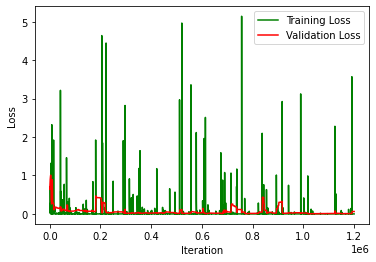

In [41]:
preprocessor = MyPreProcessor()
X, y = preprocessor.pre_process(2)
X_test=X[:X.shape[0]//8]
y_test=y[:y.shape[0]//8]

X_train=X[X.shape[0]//8:]
y_train=y[y.shape[0]//8:]

logistic = MyLogisticRegression()
logistic.fit(X_train, y_train,X_test,y_test,alpha=0.01)
print(logistic.training_acc[-1],logistic.validation_acc[-1])
logistic.plot_loss()

## Sklearn Model

In [9]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [39]:
preprocessor = MyPreProcessor()
x, y = preprocessor.pre_process(2)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=4)
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)
y_pred = logistic_regression.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy Test:",accuracy)
y_pred1 = logistic_regression.predict(x_train)
accuracy = metrics.accuracy_score(y_train, y_pred1)
print("Accuracy Train:",accuracy)
print("Thetas:",logistic_regression.coef_)


Accuracy Test: 0.9795918367346939
Accuracy Train: 0.9825072886297376
Thetas: [[-4.58128443 -4.68888037 -4.27457391  0.23536925]]


# Testing


In [34]:
Xtrain = np.array([[1, 2, 3], 
                   [4, 5, 6]])
ytrain = np.array([1, 2])

Xtest = np.array([[7, 8, 9]])
ytest = np.array([3])

print('Linear Regression')

linear = MyLinearRegression()
linear.fit(Xtrain, ytrain)

ypred = linear.predict(Xtest)

print('Predicted Values:', ypred)
print('True Values:', ytest)

print('Logistic Regression')

logistic = MyLogisticRegression()
logistic.fit(Xtrain, ytrain)

ypred = logistic.predict(Xtest)

print('Predicted Values:', ypred)
print('True Values:', ytest)

Linear Regression
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Predicted Values: [3.47084775]
True Values: [3]
Logistic Regression
Predicted Values: [1.]
True Values: [3]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
